### Experiments with training spectral bias

Imports

In [2]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import heapq
import os
from datetime import datetime
import argparse
import torch.nn.functional as F

Set save to True if you want to save plots

In [3]:
save = True

Only for python script: uncomment if running on cluster

In [4]:
# These are both placeholders
num_epochs = 1000
model_name = 'f0'

In [5]:
# # Parse command-line arguments
# parser = argparse.ArgumentParser(description='Train a neural network model')
# parser.add_argument('--epochs', type=int, default=1000, help='Number of training epochs')
# parser.add_argument('--model_name', type=str, default='model', help='Name of the saved model')
# args = parser.parse_args()

# # Use the parsed arguments
# num_epochs = args.epochs
# model_name = args.model_name

Check if CUDA is available

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [7]:
# For reproducibility
seed = 42

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)

**Simplified function generation**

In [8]:
def generate_freq_dataset(num_samples, num_points, min_freq, max_freq):
    x = torch.linspace(0, 2 * np.pi, num_points, requires_grad=True)
    functions = []
    derivatives = []
    
    for _ in range(num_samples):
        num_freqs = torch.randint(min_freq, max_freq * 2, (1,)).item()
        amplitudes = torch.rand(num_freqs * 2)  # Double the number of amplitudes
        frequencies = torch.randint(min_freq, max_freq + 1, (num_freqs,)).float()
        phases = torch.rand(num_freqs * 2) * 2 * np.pi  # Double the number of phases
        
        y = sum(a * torch.sin(f * x + p) for a, f, p in zip(amplitudes[:num_freqs], frequencies, phases[:num_freqs])) + \
            sum(a * torch.cos(f * x + p) for a, f, p in zip(amplitudes[num_freqs:], frequencies, phases[num_freqs:]))
        
        dy_dx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
        
        functions.append(y.detach().numpy())
        derivatives.append(dy_dx.detach().numpy())
    
    return np.array(functions), np.array(derivatives)

## Generate datasets

In [9]:
num_samples = 500
num_points = 1000
batch_size = 32

low_freq_functions, low_freq_derivatives = generate_freq_dataset(num_samples, num_points, 1, 5)
general_freq_functions, general_freq_derivatives = generate_freq_dataset(num_samples, num_points, 1, 15)
high_freq_functions, high_freq_derivatives = generate_freq_dataset(num_samples, num_points, 10, 15)

low_freq_dataset = TensorDataset(torch.tensor(low_freq_functions), torch.tensor(low_freq_derivatives))
general_freq_dataset = TensorDataset(torch.tensor(general_freq_functions), torch.tensor(general_freq_derivatives))
high_freq_dataset = TensorDataset(torch.tensor(high_freq_functions), torch.tensor(high_freq_derivatives))

low_freq_dataloader = DataLoader(TensorDataset(torch.tensor(low_freq_functions), torch.tensor(low_freq_derivatives)), batch_size=batch_size, shuffle=True)
high_freq_dataloader = DataLoader(TensorDataset(torch.tensor(high_freq_functions), torch.tensor(high_freq_derivatives)), batch_size=batch_size, shuffle=True)
general_freq_dataloader = DataLoader(TensorDataset(torch.tensor(general_freq_functions), torch.tensor(general_freq_derivatives)), batch_size=batch_size, shuffle=True)

In [10]:
total_size = len(low_freq_dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)

# low freq
train_dataset_l, test_dataset_l = random_split(low_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_l = DataLoader(train_dataset_l, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_l = DataLoader(test_dataset_l, batch_size=32, shuffle=False, drop_last=True)

# general freq
train_dataset_g, test_dataset_g = random_split(general_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_g = DataLoader(train_dataset_g, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_g = DataLoader(test_dataset_g, batch_size=32, shuffle=False, drop_last=True)

# high freq
train_dataset_h, test_dataset_h = random_split(high_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_h = DataLoader(train_dataset_h, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_h = DataLoader(test_dataset_h, batch_size=32, shuffle=False, drop_last=True)


## Plot random function from one of the datasets

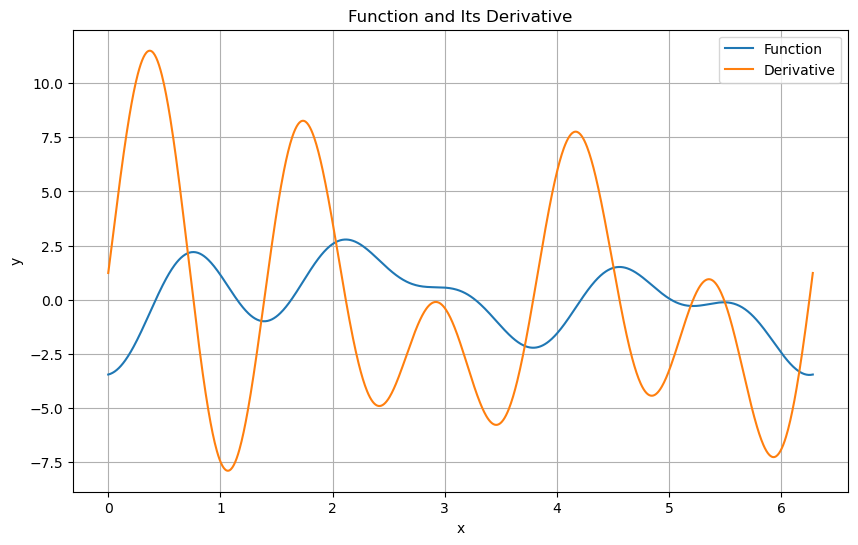

In [11]:
a = np.random.randint(32)

fun, deriv = next(iter(low_freq_dataloader))

first_function = fun[a]
first_derivative = deriv[a]

# Generate x values corresponding to the function inputs
x_values = np.linspace(0, 2 * np.pi, 1000)

# Plotting the function and its derivative
plt.figure(figsize=(10, 6))
plt.plot(x_values, first_function, label='Function')
plt.plot(x_values, first_derivative, label='Derivative')
plt.title('Function and Its Derivative')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

## Miscellaneous plotting functions

In [12]:
def plot_losses(train_losses, test_losses, save_dir='plots', filename=None, save=False):
    if not train_losses:
        return
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    current_date = datetime.now().strftime("%m-%d")
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, linestyle='-', color='b', label='Training Loss')
    plt.plot(epochs, test_losses, linestyle='-', label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')  # Set the y-axis to logarithmic scale
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"
    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)    
    plt.show()

In [13]:
def plot_output(model1, dataset, order=None, save_dir='plots', filename=None, save=False): 
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    current_date = datetime.now().strftime("%m-%d")
    model1.eval()  # Set the model to evaluation mode

    train_dataloader_viz = get_random_function(dataset, shuffle=True)
    # Get a random sample from the dataloader
    dataiter = iter(train_dataloader_viz)
    function, true_derivative = next(dataiter)

    # Reshape the input for the model
    function = function.unsqueeze(1)  # Add channel dimension

    # Make prediction
    with torch.no_grad():
        if order == 1 or order == 2:
            predicted_derivative = model1(function)
        
        if order == 'rollout':
            predicted_derivative = model1(function)
            predicted_derivative = model1(predicted_derivative)

    # Convert tensors to numpy arrays for plotting
    x = torch.linspace(0, 2*torch.pi, 1000).numpy()
    function = function.squeeze().numpy()

    predicted_derivative = predicted_derivative.squeeze().numpy()

    true_derivative = true_derivative.squeeze().numpy()

    # Plot the results
    plt.figure(figsize=(12, 6))

    plt.plot(x, function, label='Original Function', color='blue')
    if order == 1:
        plt.plot(x, true_derivative, label=f'True {order}st derivative')

    plt.plot(x[10:-10], predicted_derivative[10:-10], label=f'Predicted {order}nd Derivative', linestyle='--')

    plt.title('Function, True Derivatives, and Predicted Derivatives')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"

    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)  
    plt.show()

In [14]:
def get_random_function(dataset, shuffle=True):
    return DataLoader(dataset, batch_size=1, shuffle=shuffle)

## Function to train model

In [15]:
criterion = nn.MSELoss()

In [16]:
train_losses, test_losses = [], []

def model_training(model, train_dataloader, test_dataloader, num_epochs,\
    split_freq=None, filename=None, save=None, order=None):
    train_losses = []
    test_losses = []

    low_freq_nmses = []
    general_freq_nmses = []
    high_freq_nmses = []
    epoch_list = []

    lr = 1e-3

    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        if epoch % split_freq == 0:
            l, g, h = print_and_store_metrics(model)
            low_freq_nmses.append(l)
            general_freq_nmses.append(g)
            high_freq_nmses.append(h)
            epoch_list.append(epoch)

        for batch_functions, batch_derivatives in train_dataloader:
            batch_functions = batch_functions.unsqueeze(1)
            batch_derivatives = batch_derivatives.unsqueeze(1)

            outputs = model(batch_functions)
            loss = criterion(outputs, batch_derivatives)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        model.eval()
        with torch.no_grad():
            for b_test_functions, b_test_derivatives in test_dataloader:
                b_test_functions = b_test_functions.unsqueeze(1)
                b_test_derivatives = b_test_derivatives.unsqueeze(1)

                test_outputs = model(b_test_functions)
                batch_test_loss = criterion(test_outputs, b_test_derivatives)

                test_loss += batch_test_loss.item()

        test_loss /= len(test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    print(f"Training finished for {order}st derivative")

    plt.figure(figsize=(10, 6))
    plt.plot(epoch_list, low_freq_nmses, label='Low freq NMSE')
    plt.plot(epoch_list, general_freq_nmses, label='General freq NMSE')
    plt.plot(epoch_list, high_freq_nmses, label='High freq NMSE')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('NMSE')
    plt.yscale('log')
    plt.title('NMSEs of different frequencies during training')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()
    if save:
        plt.savefig(filename)  

    return train_losses, test_losses

## Metric functions

In [17]:
def compute_mse(dataloader, model):
    """
    Takes in a dataloader and a model to compute MSE.
    """

    model.eval()
    all_outputs = []
    all_targets = []

    for function, deriv in dataloader:
        function = function.unsqueeze(1)
        deriv = deriv.unsqueeze(1)

        # Compute model output
        model_output = model(function)
        all_targets.append(deriv)

        # Collect outputs
        all_outputs.append(model_output)

    # Concatenate all collected outputs and targets
    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Compute MSE
    mse = torch.mean((all_targets - all_outputs) ** 2)
    nmse = mse / torch.mean(all_targets ** 2)

    return mse.item(), nmse.item()

criterion = torch.nn.MSELoss()

In [18]:
def print_and_store_metrics(f0):
    return compute_mse(test_dataloader_l, f0)[1], compute_mse(test_dataloader_g, f0)[1], compute_mse(test_dataloader_h, f0)[1]

In [19]:
def print_metrics(model):
    print(f"NMSE over low freq test functions: {compute_mse(test_dataloader_l, model)[1]}")
    print(f"NMSE over general freq test functions: {compute_mse(test_dataloader_g, model)[1]}")
    print(f"NMSE over high freq test functions: {compute_mse(test_dataloader_h, model)[1]}")



## Create models

In [20]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self, n_layers=3, kernel_size=3, hidden_size=64):
        super(SimpleCNN, self).__init__()
        # Parameters
        self.n_layers = n_layers
        self.kernel_size = kernel_size
        self.hidden_size = hidden_size

        # Model
        self.convs = nn.ModuleList()
        if n_layers == 1:
            self.convs.append(nn.Conv1d(1, 1, kernel_size=kernel_size, padding=kernel_size//2))
        elif n_layers >= 2:
            self.convs.append(nn.Conv1d(1, hidden_size, kernel_size=kernel_size, padding=kernel_size//2))
            for _ in range(n_layers - 2):
                self.convs.append(nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=kernel_size//2))
            self.convs.append(nn.Conv1d(hidden_size, 1, kernel_size=kernel_size, padding=kernel_size//2))
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        for i, conv in enumerate(self.convs):
            if i < len(self.convs) - 1:
                x = self.relu(conv(x))
            else:
                x = conv(x)
        return x

In [21]:
set_seed(seed)
L3ModelK3 = SimpleCNN(n_layers=3, kernel_size=3)

In [22]:
# train_losses, test_losses = model_training(L3ModelK3, train_dataloader_g, test_dataloader_g,\
#     num_epochs=1000, split_freq=10, filename='../plots/spectral_bias/f0_E2000_phased_training',\
#     save=save, order='first')
# plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

## Plot results

In [23]:
def plot_all_outputs(model, model_name):
    plot_output(model, dataset=test_dataset_l, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)
    plot_output(model, dataset=test_dataset_g, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)
    plot_output(model, dataset=test_dataset_h, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)

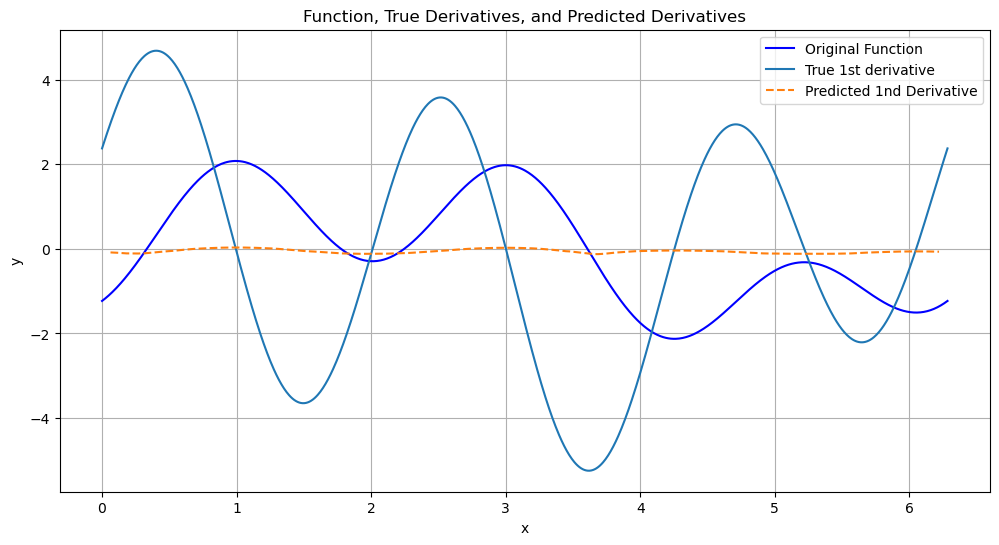

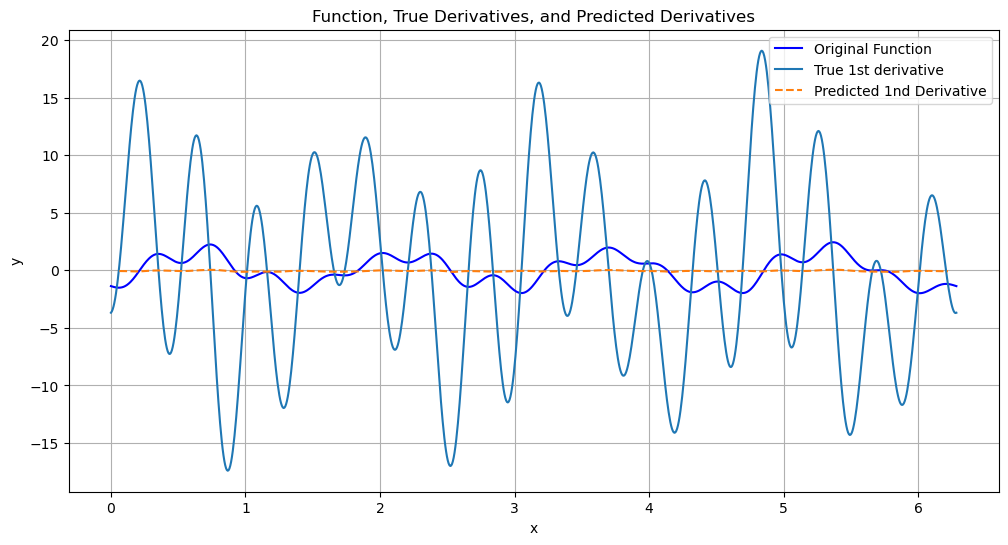

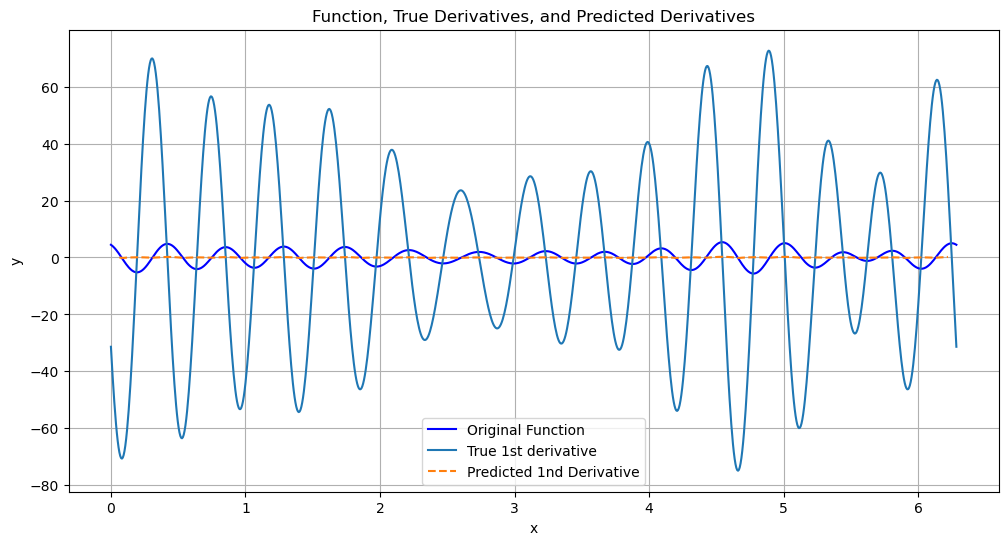

In [24]:
plot_all_outputs(L3ModelK3, model_name = 'L3ModelK3')

In [25]:
print_metrics(L3ModelK3)

NMSE over low freq test functions: 0.9994839429855347
NMSE over general freq test functions: 0.9994645118713379
NMSE over high freq test functions: 0.9995222091674805


In [26]:
print(L3ModelK3)

SimpleCNN(
  (convs): ModuleList(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (2): Conv1d(64, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (relu): ReLU()
  (tanh): Tanh()
)


**3 layer model with kernel size 9**

In [27]:
set_seed(seed)
L3ModelK9 = SimpleCNN(n_layers=3, kernel_size=9)

In [28]:
# train_losses, test_losses = model_training(L3ModelK9, train_dataloader_g, test_dataloader_g,\
#     num_epochs=1000, split_freq=10, filename='../plots/spectral_bias/f0_E2000_phased_training',\
#     save=save, order='first')
# plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

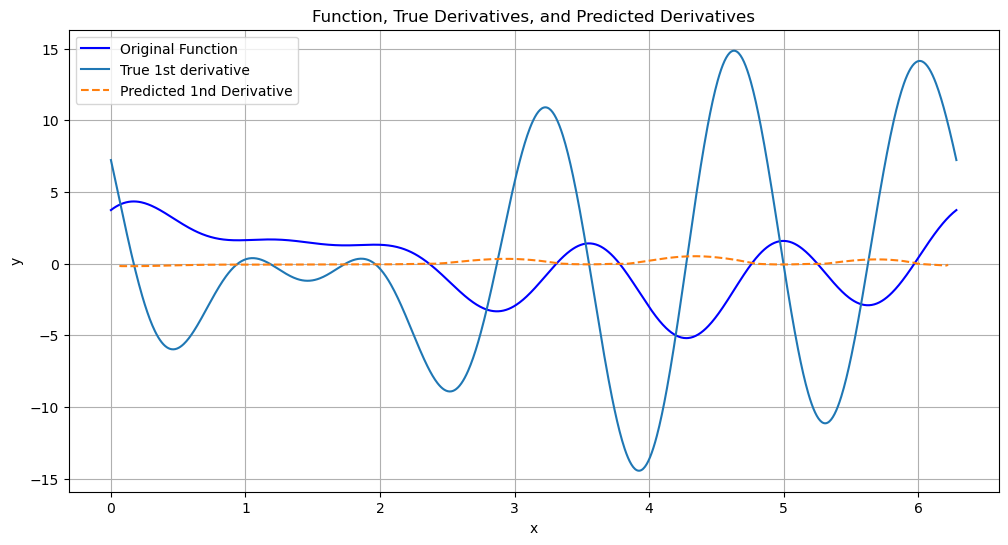

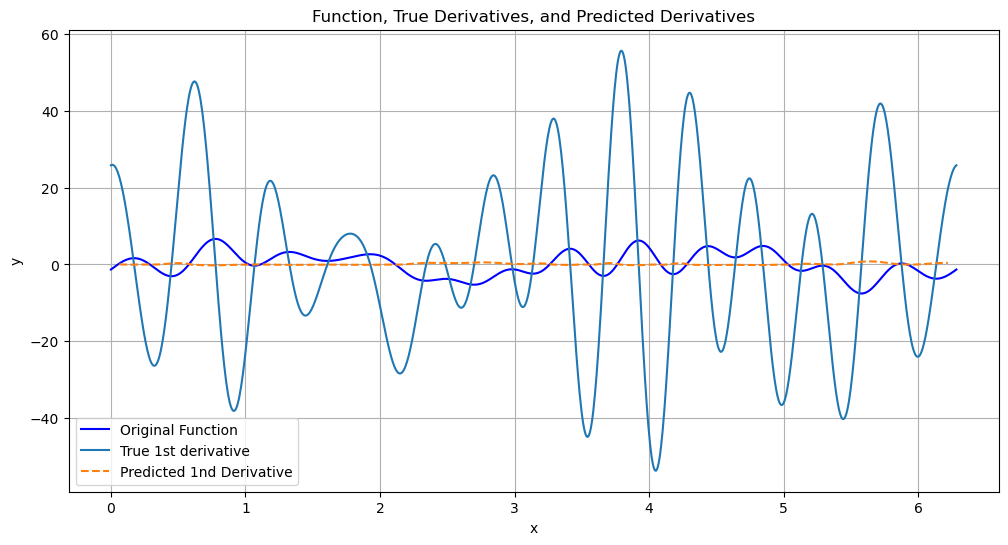

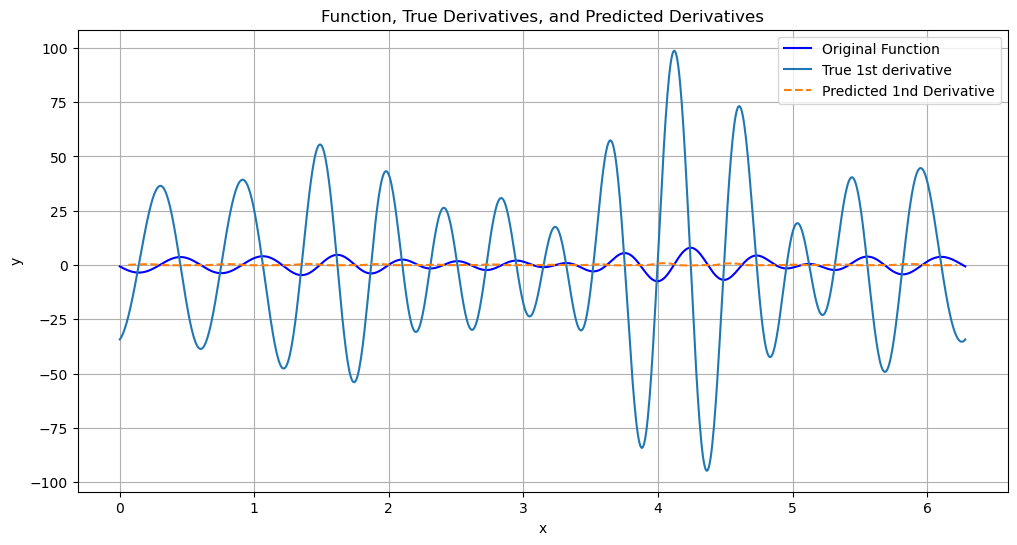

In [29]:
plot_all_outputs(L3ModelK9, model_name='L3ModelK9')

In [30]:
print_metrics(L3ModelK9)
print(L3ModelK9)

NMSE over low freq test functions: 0.9949268102645874
NMSE over general freq test functions: 0.9951961636543274
NMSE over high freq test functions: 0.9954105019569397
SimpleCNN(
  (convs): ModuleList(
    (0): Conv1d(1, 64, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): Conv1d(64, 64, kernel_size=(9,), stride=(1,), padding=(4,))
    (2): Conv1d(64, 1, kernel_size=(9,), stride=(1,), padding=(4,))
  )
  (relu): ReLU()
  (tanh): Tanh()
)


**3 layer model with kernel size 12**

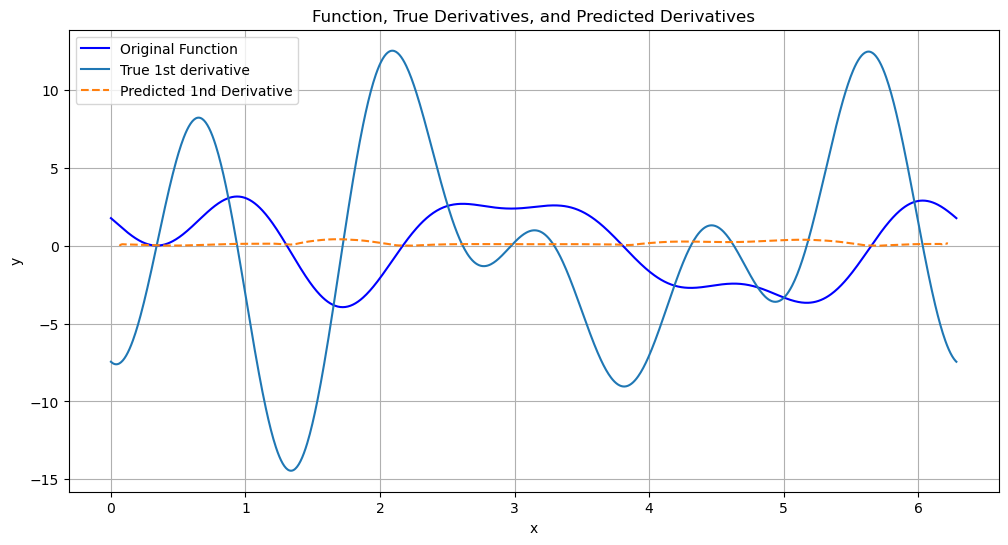

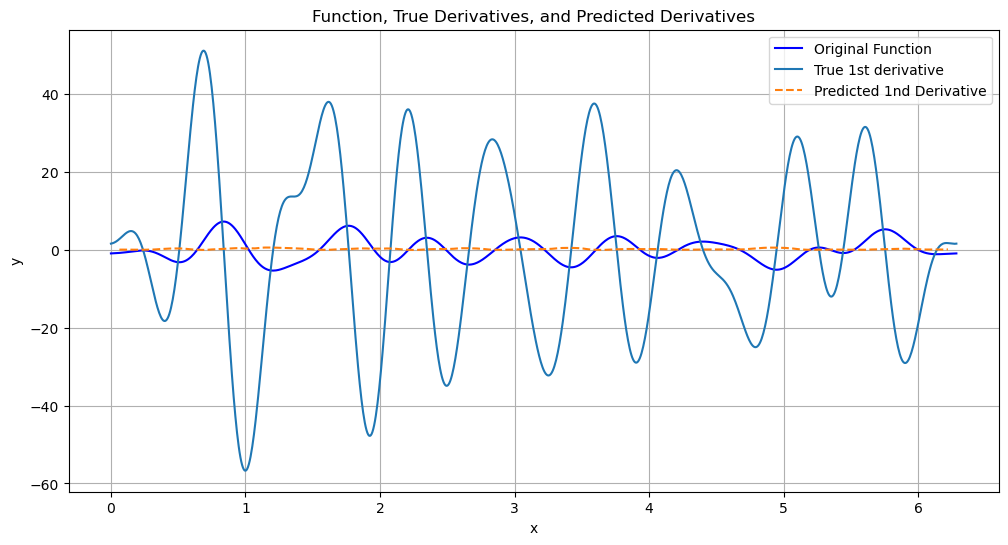

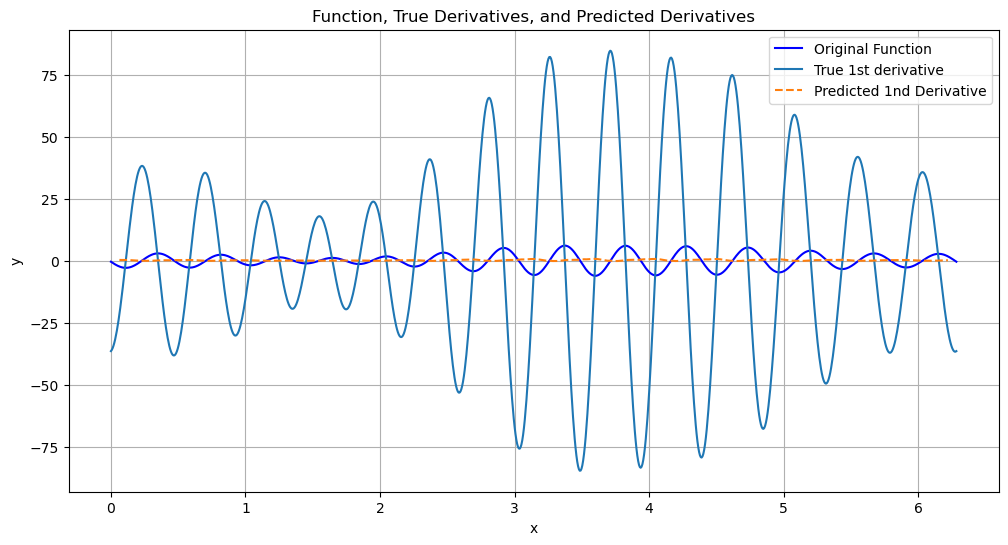

In [31]:
set_seed(seed)
L3ModelK15 = SimpleCNN(n_layers=3, kernel_size=15)
plot_all_outputs(L3ModelK15, model_name='L3ModelK15')

In [32]:
print(compute_mse(train_dataloader_l, L3ModelK15)[1])

1.0060919523239136


## Changing model depth

In [43]:
def train_varying_model_size(model_sizes, train_dataloader, test_dataloader, num_epochs,\
    split_freq=None, filename=None, save=None, save_model=False, order=None):
    all_train_losses = []
    all_test_losses = []

    general_freq_nmse_dict = {}
    low_freq_nmse_dict = {}
    high_freq_nmse_dict = {}

    epoch_list = []

    avg_gen_nmse_last_50_epochs = np.zeros(len(model_sizes))
    avg_low_nmse_last_50_epochs = np.zeros(len(model_sizes))
    avg_high_nmse_last_50_epochs = np.zeros(len(model_sizes))

    lr = 1e-3

    for i, model_size in enumerate(model_sizes):
        # Set the seed each time we increase the num of layers in the model
        set_seed(seed)
        model = SimpleCNN(n_layers=model_size, kernel_size=3)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        train_losses = []
        test_losses = []
        general_freq_nmses = []
        low_freq_nmses = []
        high_freq_nmses = []

        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0
            test_loss = 0.0

            # Calculate the metrics at every iteration
            l, g, h = print_and_store_metrics(model)
            general_freq_nmses.append(g)
            low_freq_nmses.append(l)
            high_freq_nmses.append(h)

            epoch_list.append(epoch)

            for batch_functions, batch_derivatives in train_dataloader:
                batch_functions = batch_functions.unsqueeze(1)
                batch_derivatives = batch_derivatives.unsqueeze(1)

                outputs = model(batch_functions)
                loss = criterion(outputs, batch_derivatives)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            train_loss /= len(train_dataloader)

            model.eval()
            with torch.no_grad():
                for b_test_functions, b_test_derivatives in test_dataloader:
                    b_test_functions = b_test_functions.unsqueeze(1)
                    b_test_derivatives = b_test_derivatives.unsqueeze(1)

                    test_outputs = model(b_test_functions)
                    batch_test_loss = criterion(test_outputs, b_test_derivatives)

                    test_loss += batch_test_loss.item()

            test_loss /= len(test_dataloader)

            train_losses.append(train_loss)
            test_losses.append(test_loss)

            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

        print(f"Training finished for {order}st derivative")

        # Store the losses for this model size
        all_train_losses.append(train_losses)
        all_test_losses.append(test_losses)

        # Store the general frequency NMSEs in the dictionary
        general_freq_nmse_dict[model_size] = general_freq_nmses
        low_freq_nmse_dict[model_size] = low_freq_nmses
        high_freq_nmse_dict[model_size] = high_freq_nmses

        # Calculate and store the average NMSE over the last 50 epochs
        # for each of the freq dataseets
        avg_gen_nmse_last_50_epochs[i] = np.mean(general_freq_nmses[-50:])
        avg_low_nmse_last_50_epochs[i] = np.mean(low_freq_nmses[-50:])
        avg_high_nmse_last_50_epochs[i] = np.mean(high_freq_nmses[-50:])

        model_path = f"../../models/{model_size}_layers.pth"
        if save_model:
            torch.save(model.state_dict(), model_path)


    ### PLOTS
    plt.figure(figsize=(20, 15))

    # Plot the general NMSEs for each model size on the same plot
    plt.subplot(2, 2, 1)
    for model_size, nmse_values in general_freq_nmse_dict.items():
        plt.plot(epoch_list[:len(nmse_values)], nmse_values, label=f'{model_size} layers')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('General freq NMSE')
    plt.yscale('log')
    plt.title('General freq NMSEs during training for different model sizes')
    plt.legend()

    # Second plot comparing the average NMSE over the last 50 epochs
    plt.subplot(2, 2, 2)
    plt.plot(model_sizes, avg_gen_nmse_last_50_epochs, 'o-', label='Avg gen NMSE over last 50 epochs')

    plt.xlabel('Layers in model (with kernel size 3)')
    plt.ylabel('Average General freq NMSE (Last 50 epochs)')
    plt.title('Average General freq NMSEs for different model depths')
    plt.legend()
    plt.grid(True)

    # Third plot comparing the average low NMSE over the last 50 epochs
    plt.subplot(2, 2, 3)
    plt.plot(model_sizes, avg_low_nmse_last_50_epochs, 'o-', label='Avg low NMSE over last 50 epochs')

    plt.xlabel('Layers in model (with kernel size 3)')
    plt.ylabel('Average General freq NMSE (Last 50 epochs)')
    plt.title('Average General freq NMSEs for different model depths')
    plt.legend()
    plt.grid(True)

    # Third plot comparing the average high NMSE over the last 50 epochs
    plt.subplot(2, 2, 4)
    plt.plot(model_sizes, avg_high_nmse_last_50_epochs, 'o-', label='Avg high NMSE over last 50 epochs')

    plt.xlabel('Layers in model (with kernel size 3)')
    plt.ylabel('Average high freq NMSE (Last 50 epochs)')
    plt.title('Average high freq NMSEs for different model depths')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    if save:
        plt.savefig(filename)  
    plt.show()

    return all_train_losses, all_test_losses, general_freq_nmse_dict, low_freq_nmse_dict, high_freq_nmse_dict


Epoch [1/10], Train Loss: 436.2529, Test Loss: 364.8524
Epoch [2/10], Train Loss: 420.8213, Test Loss: 347.6241
Epoch [3/10], Train Loss: 390.9786, Test Loss: 316.2301
Epoch [4/10], Train Loss: 351.8500, Test Loss: 266.4910
Epoch [5/10], Train Loss: 281.9650, Test Loss: 199.8706
Epoch [6/10], Train Loss: 193.1876, Test Loss: 122.4582
Epoch [7/10], Train Loss: 105.4752, Test Loss: 55.9437
Epoch [8/10], Train Loss: 42.9621, Test Loss: 19.5312
Epoch [9/10], Train Loss: 18.4946, Test Loss: 12.4566
Epoch [10/10], Train Loss: 15.6225, Test Loss: 12.0978
Training finished for Nonest derivative
Epoch [1/10], Train Loss: 439.4489, Test Loss: 355.6477
Epoch [2/10], Train Loss: 315.6539, Test Loss: 88.4957
Epoch [3/10], Train Loss: 78.5774, Test Loss: 33.9579
Epoch [4/10], Train Loss: 34.7543, Test Loss: 16.7859
Epoch [5/10], Train Loss: 19.4997, Test Loss: 11.3019
Epoch [6/10], Train Loss: 13.2658, Test Loss: 10.0701
Epoch [7/10], Train Loss: 9.5921, Test Loss: 6.8386
Epoch [8/10], Train Loss: 7

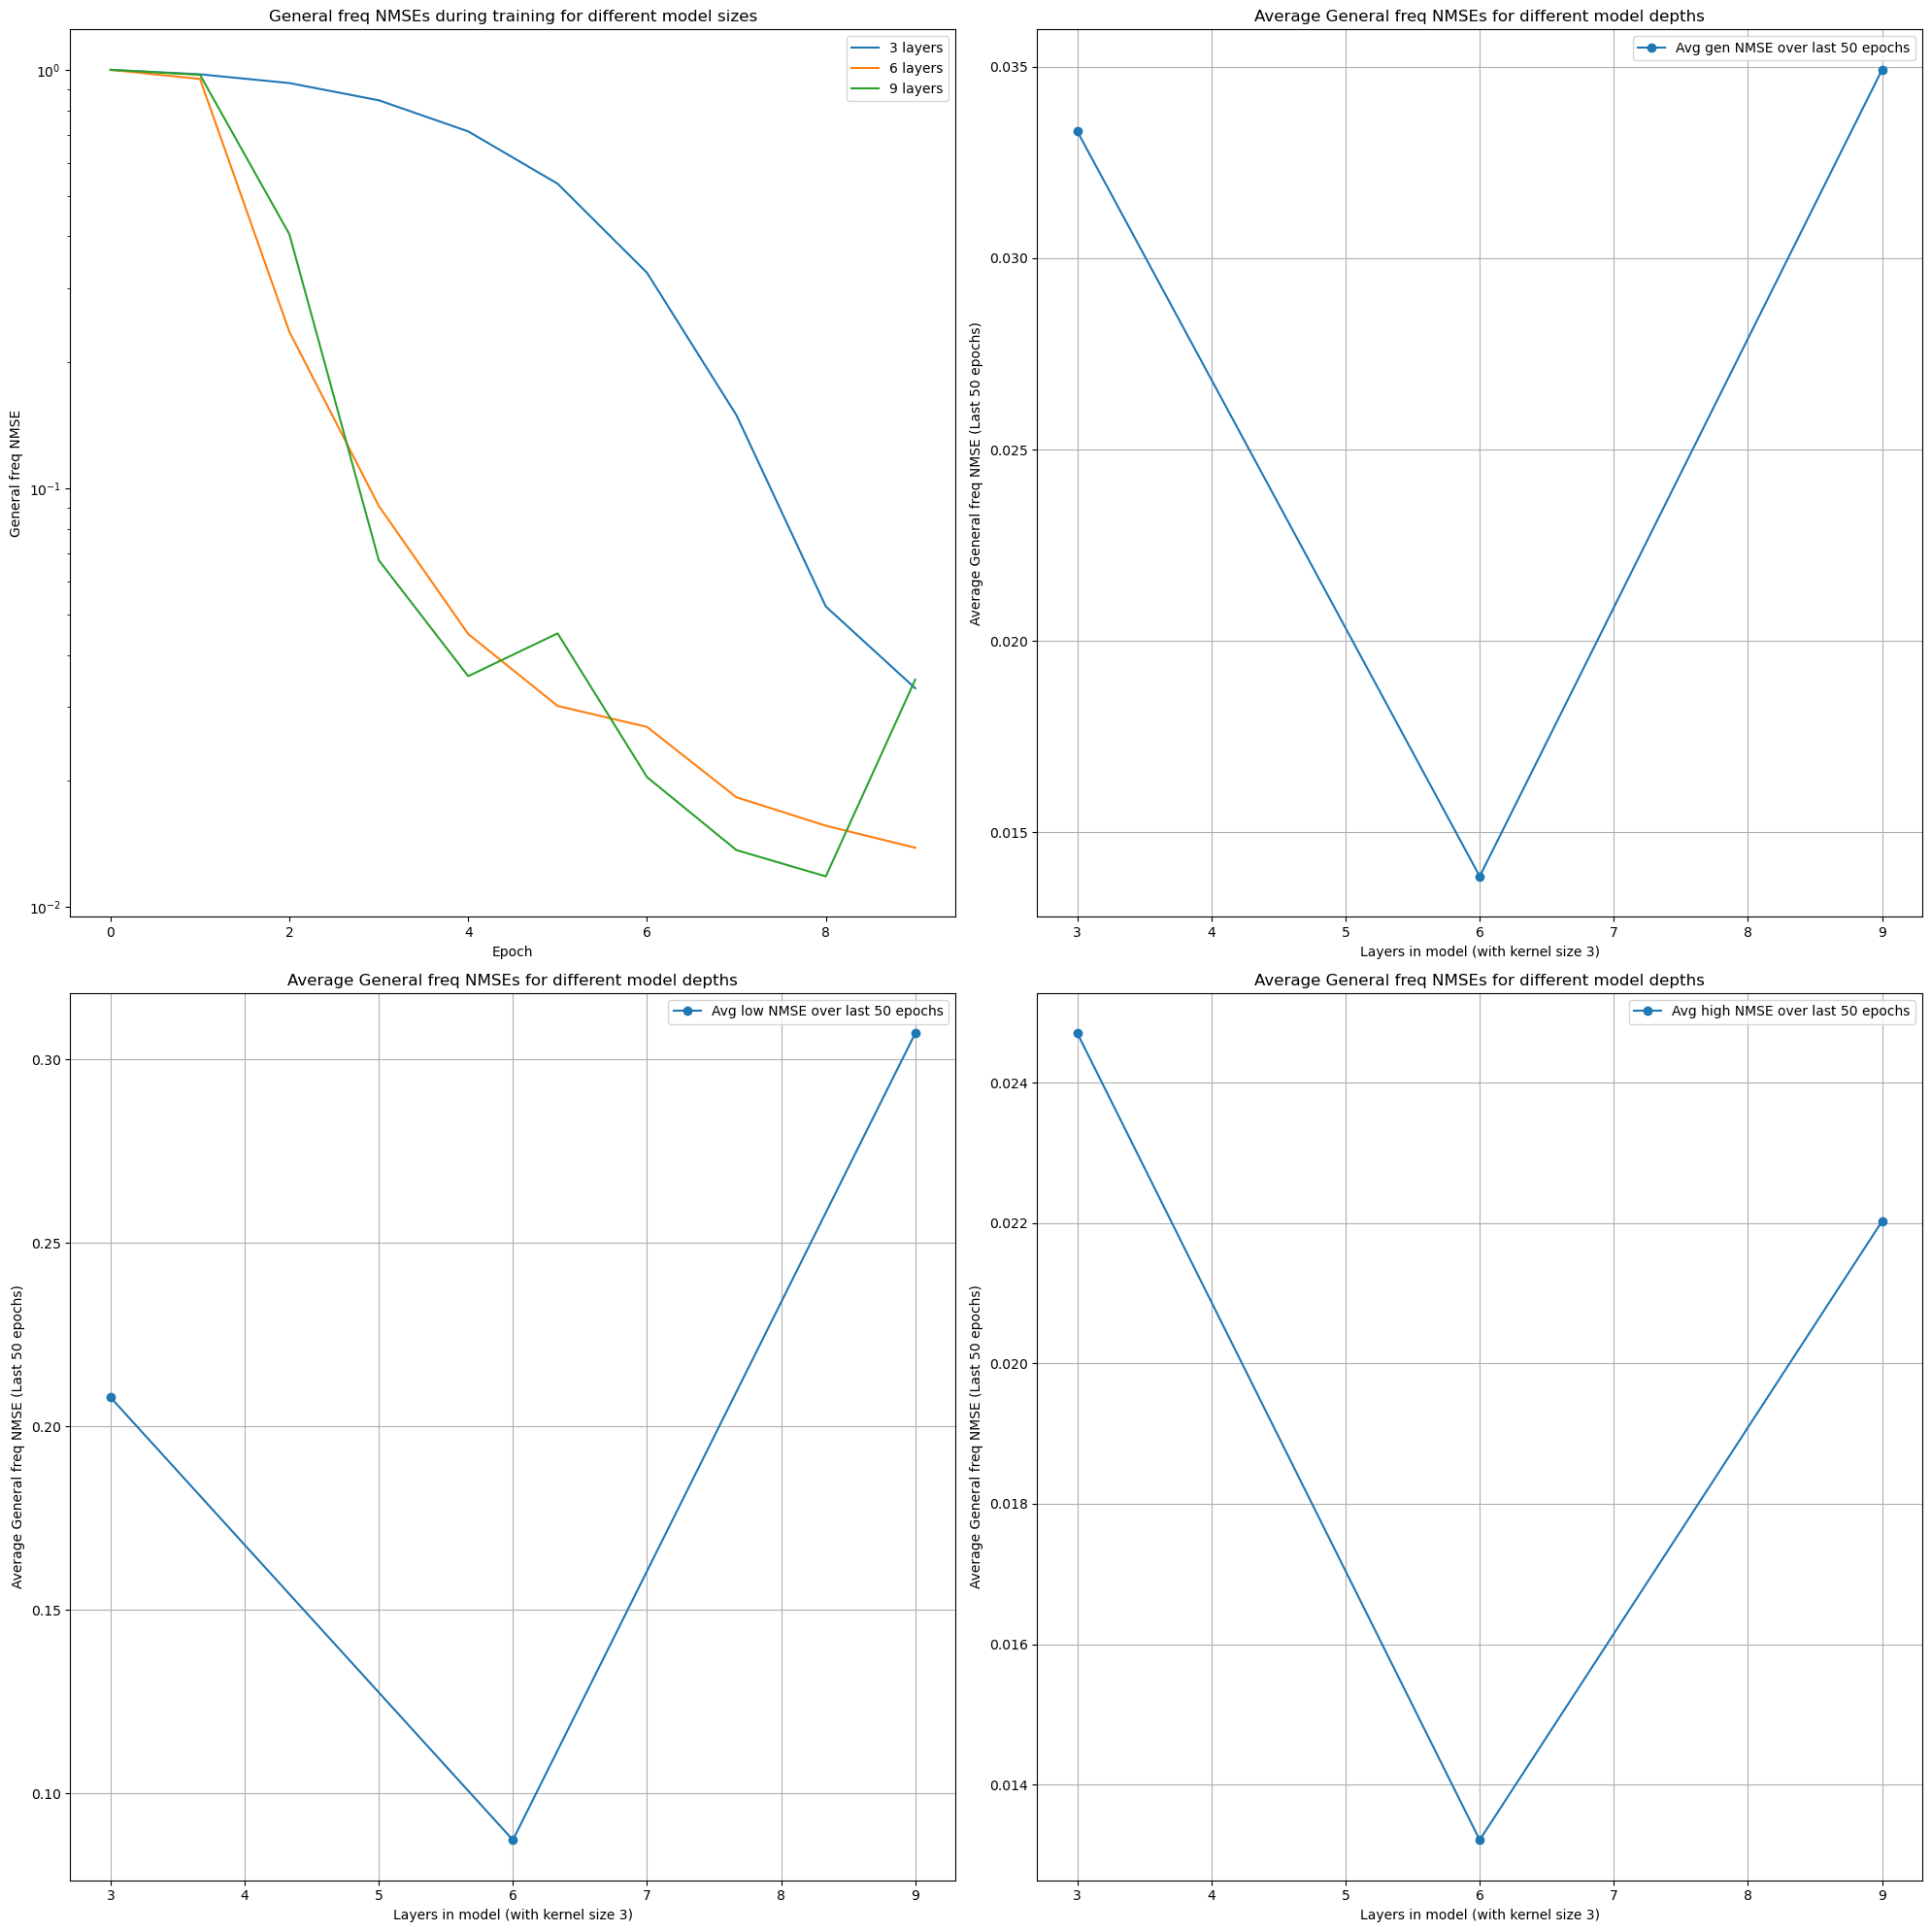

([[436.2529296875,
   420.82128651936847,
   390.9786148071289,
   351.84996795654297,
   281.965025583903,
   193.18761571248373,
   105.47524706522624,
   42.962132930755615,
   18.49464813868205,
   15.622458934783936],
  [439.44889068603516,
   315.65386962890625,
   78.57736603418986,
   34.754342238108315,
   19.4997452100118,
   13.265774170557657,
   9.592053731282553,
   7.513875166575114,
   6.488574862480164,
   5.685924728711446],
  [436.08652750651044,
   335.8916549682617,
   105.44035577774048,
   42.81386844317118,
   20.00863806406657,
   11.643011609713236,
   8.123945871988932,
   6.436637878417969,
   5.757689555486043,
   12.479624648888906]],
 [[364.85243733723956,
   347.6240743001302,
   316.2301330566406,
   266.4910125732422,
   199.87063598632812,
   122.45823923746745,
   55.94366709391276,
   19.531163533528645,
   12.456568241119385,
   12.097803115844727],
  [355.6476643880208,
   88.49568430582683,
   33.95786794026693,
   16.785861333211262,
   11.30187

In [44]:
# model_sizes = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
model_sizes = [3, 6, 9]

train_varying_model_size(model_sizes, train_dataloader_g, test_dataloader_g,\
    num_epochs=1000, split_freq=10, filename='../../plots/spectral_bias/different_layers_loss', save=save, save_model=False, order=None)